In [1]:
from matplotlib import pyplot as plt
import xml.etree.ElementTree as et
import numpy as np

<b>The root element defined in this cell will be passed to functions in later cells

In [2]:
file_path = "20230328_KRISS_K157_611_20_0nm_60s_10x10ptsdet_1_0_0.spx"
root = et.parse(file_path).getroot()

In [3]:
def getIntensity(r, z):
    """z can be an int or string representing atomic number of element. (not a float)
    returns net intensity of element z"""
    result = r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTResult']/RoiResults/Atom[.='"
                         + str(z)
                         + "']/..")
    if len(result) == 0:
        return 0
    else:
        print(result[0].findall("./Description")[0].text, "Peak")
        return int(result[0].findall("./NetCounts")[0].text)

In [4]:
def getEnergyAxis(r):
    num_channels = int(r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTSpectrumHeader']/"
                                 "ChannelCount")[0].text)
    chan_to_en_m = float(r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTSpectrumHeader']/"
                                 "CalibLin")[0].text)
    chan_to_en_b = float(r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTSpectrumHeader']/"
                                 "CalibAbs")[0].text)
    return np.arange(0, 4096)*chan_to_en_m + chan_to_en_b

In [5]:
def getRawCountsData(r):
    data = r.findall("./ClassInstance[@Type='TRTSpectrum']/Channels")[0].text.split(",")
    for i in range(0, len(data)):
        data[i] = int(data[i])
        
    return np.array(data)

In [6]:
def getBackgroundData(r):
    background = r.findall("./ClassInstance[@Type='TRTSpectrum']/ChildClassInstances/ClassInstance"
          "[@Type='TRTXRFBulkQuantificationResults']/TRTSpectrumQuantificationResults/"
          "ClassInstance[@Type='TRTSpectrumList']/ChildClassInstances/ClassInstance"
          "[@Type='TRTSpectrum']/Channels")[0].text.split(",")
    for i in range(0, len(background)):
        background[i] = float(background[i])
        
    return np.array(background)

Hf-LA Peak
Si-K Peak
0.017815805132733172


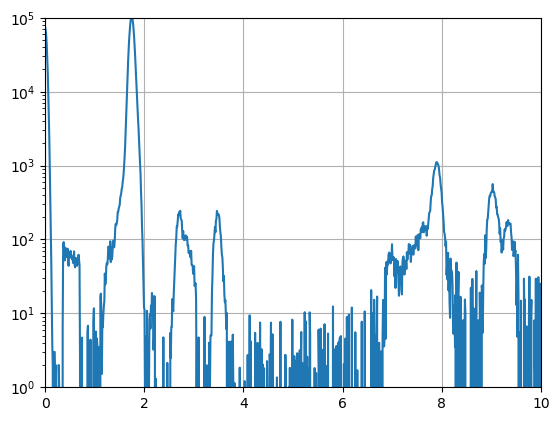

In [7]:
print(getIntensity(root, 72)/getIntensity(root, 14))

f, ax = plt.subplots()
ax.semilogy(getEnergyAxis(root), getRawCountsData(root) - getBackgroundData(root))

ax.axis([0, 10, 1, 100000])
ax.grid(True)
plt.show()